<a href="https://colab.research.google.com/github/fralfaro/MAT281_2023/blob/main/docs/labs/lab_072.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT281 - Laboratorio N°072


<a id='p1'></a>
## I.- Problema 01


<img src="https://drive.google.com/uc?export=view&id=1hG9C4e6Tisw2VTEatGkP_hRmnZNpbXK4" width = "300" align="center"/>


El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento.

* Se solicita ajustar al menos tres modelos de clasificación:
     * Regresión logística
     * K-Nearest Neighbours
     * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning).

* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_.
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)

### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [64]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import time

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import preprocessing

from itertools import cycle

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [54]:
# Funciones
def mae(targets, predictions) -> float:
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)

def mape(targets, predictions) -> float:
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)

def maape(targets, predictions) -> float:
    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)

def wmape(targets, predictions) -> float:
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)

def mmape(targets, predictions) -> float:
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)

def smape(targets, predictions) -> float:
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def classification_metrics(df: pd.DataFrame)->pd.DataFrame:
    y_true = df['y']
    y_pred = df['yhat']

    accuracy = round(accuracy_score(y_true, y_pred), 4)
    recall = round(recall_score(y_true, y_pred, average='macro'), 4)
    precision = round(precision_score(y_true, y_pred, average='macro'), 4)
    fscore = round(f1_score(y_true, y_pred, average= 'macro'), 4)

    df_result = pd.DataFrame({'accuracy':[accuracy],
                              'recall':[recall],
                              'precision':[precision],
                              'fscore':[fscore]})
    return df_result

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nMétricas de calificación:")
    metrics_df = classification_metrics(pd.DataFrame({'y':y_test, 'yhat':y_pred}))
    print(metrics_df)

In [55]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [56]:
# informacion de las columnas
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [57]:
# informacion del target
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [58]:
# leer datos
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
* ¿Cuánta memoria estoy utilizando?
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [39]:
# Distribución
digits.describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [40]:
# Información
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   c00     1797 non-null   int64
 1   c01     1797 non-null   int64
 2   c02     1797 non-null   int64
 3   c03     1797 non-null   int64
 4   c04     1797 non-null   int64
 5   c05     1797 non-null   int64
 6   c06     1797 non-null   int64
 7   c07     1797 non-null   int64
 8   c08     1797 non-null   int64
 9   c09     1797 non-null   int64
 10  c10     1797 non-null   int64
 11  c11     1797 non-null   int64
 12  c12     1797 non-null   int64
 13  c13     1797 non-null   int64
 14  c14     1797 non-null   int64
 15  c15     1797 non-null   int64
 16  c16     1797 non-null   int64
 17  c17     1797 non-null   int64
 18  c18     1797 non-null   int64
 19  c19     1797 non-null   int64
 20  c20     1797 non-null   int64
 21  c21     1797 non-null   int64
 22  c22     1797 non-null   int64
 23  c23     1797 

La memoría utilizada son 912.7 KB y todos los datos son del tipo int64

In [41]:
# Registros por clase
digits["target"].value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: target, dtype: int64

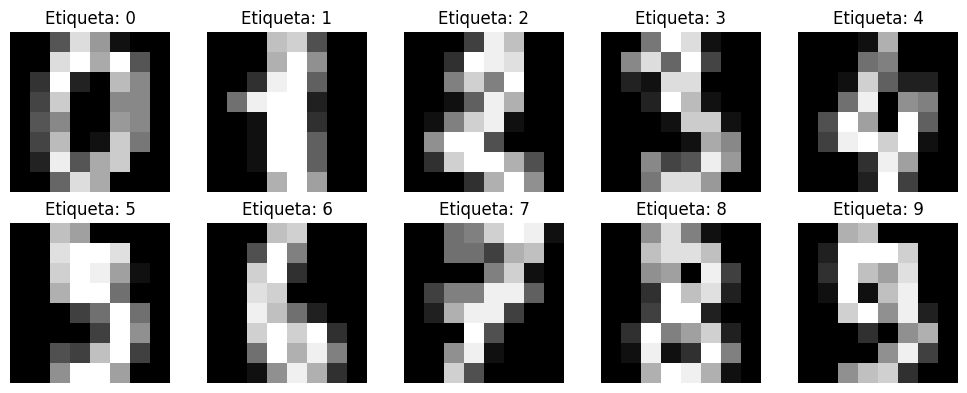

In [42]:
# Graficar imágenes de muestra
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.iloc[i, :-1].values.reshape(8, 8), cmap="gray")
    ax.set_title(f"Etiqueta: {digits.iloc[i, -1]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [43]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`.

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

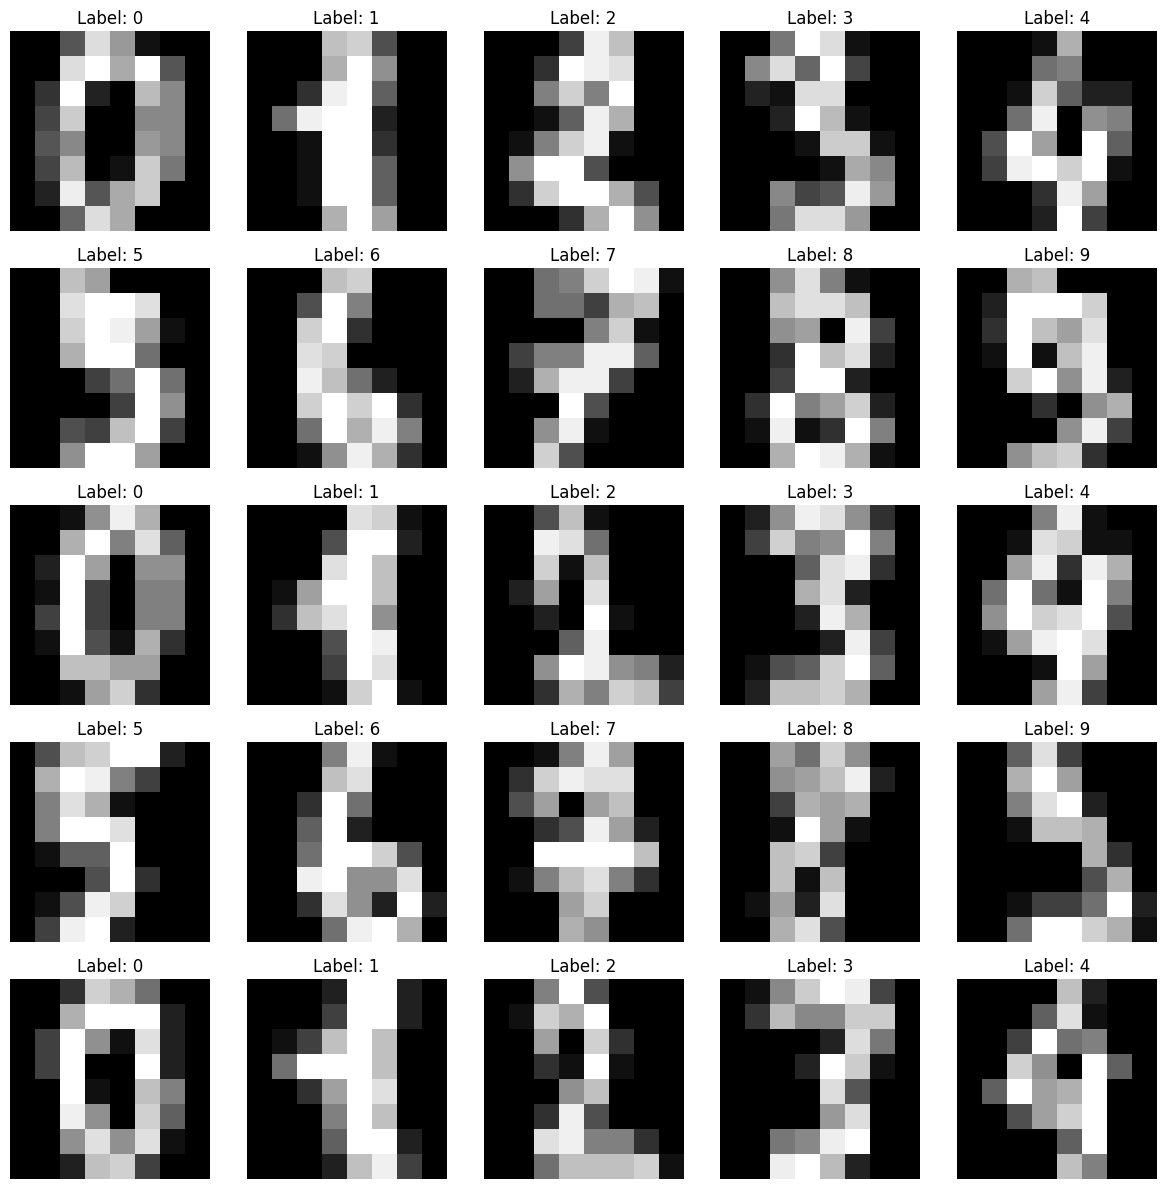

In [44]:
nx, ny = 5, 5
fig, axs = plt.subplots(nx, ny, figsize=(12, 12))

for i, ax in enumerate(axs.flat):
    ax.imshow(digits_dict["images"][i], cmap="gray")
    ax.set_title(f"Label: {digits_dict['target'][i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test**
     * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
     * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
  
* **modelo**:
     * Instanciar el modelo objetivo desde la librería sklearn.

* **Métricas**:
     * Graficar matriz de confusión.
     * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [45]:
# features, target
X = digits.drop(columns="target").values
y = digits["target"].values

# spli dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [46]:
print("Largo X Train:\n", len(X_train))
print("Largo X Test:\n", len(X_test))

Largo X Train:
 1437
Largo X Test:
 360


In [47]:
# Modelos
log_model = LogisticRegression(solver='sag', max_iter=1000)
knn_model = KNeighborsClassifier()
rand_forest_model = RandomForestClassifier()

# Entregar los modelos
log_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)
rand_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [73]:
# Tablas de confusión
models = [log_model, knn_model, rand_forest_model]
model_names = ["Regresión Logística", "K-Nearest Neighbors", "Random Forest"]

for i in range(3):
    print("Métricas para el modelo de " + model_names[i] + ":\n")
    evaluate_model(models[i], X_test, y_test)
    print("\n")

Métricas para el modelo de Regresión Logística:

Matriz de confusión:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  1  0  0 45  0  0  0  0  0]
 [ 0  0  1  0  0 44  1  0  0  1]
 [ 0  0  0  0  0  1 34  0  0  0]
 [ 0  0  0  0  0  1  0 33  0  0]
 [ 0  0  0  0  0  1  0  0 29  0]
 [ 0  0  0  1  0  0  0  0  1 38]]

Métricas de calificación:
   accuracy  recall  precision  fscore
0    0.9722  0.9744     0.9736  0.9739


Métricas para el modelo de K-Nearest Neighbors:

Matriz de confusión:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 45  1  0  0  1]
 [ 0  0  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 33  0  1]
 [ 0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  1  1  0  0  0 38]]

Métricas de calificación:
   accuracy  recall  precision  fscore
0    0.9861  0.9878     0

In [69]:
# Tabla de modelos
results = []

# Evaluar Métricas
y_pred_logistic, y_pred_knn, y_pred_random_forest = 0, 0, 0
logistic_metrics, knn_metrics, random_forest_metric =  0, 0, 0

predictions = [y_pred_logistic, y_pred_knn, y_pred_random_forest]
metrics = [logistic_metrics, knn_metrics, random_forest_metric]
models_code = ['logistic', 'knn', 'random forest']
models_time = []

for i in range(3):
    t0 = time.time()
    predictions[i] = models[i].predict(X_test)
    models_time.append(time.time()-t0)
    metrics[i] = classification_metrics(pd.DataFrame({'y':y_test, 'yhat':predictions[i]}))
    results.append(metrics[i].assign(model = models_code[i]))

# Concatenar resultados en la df
df_results = pd.concat(results).reset_index(drop=True).sort_values('accuracy')
df_results['time'] = models_time

print("Resultados de métricas para los tres modelos")
df_results

Resultados de métricas para los tres modelos


,accuracy,recall,precision,fscore,model,time
0,0.9722,0.9744,0.9736,0.9739,logistic,0.000674
2,0.9806,0.9803,0.9810,0.9805,random forest,0.116575
1,0.9861,0.9878,0.9879,0.9878,knn,0.021046


El modelo KNN es el que mejor funciona, pues la exactitud nos indica que los falsos negativos y falsos positivos son mínimos, respecto a los otros modelos. Esto pues, el valor de accuracy para KNN es el más cercano a 1.

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el **mejor modelo entontrado** en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:


 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

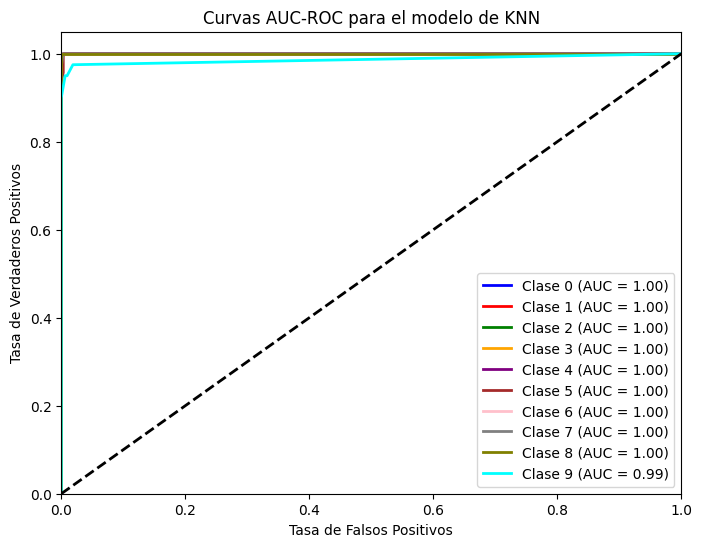

In [59]:
# Obtener las probabilidades de predicción para cada clase
y_pred_proba = knn_model.predict_proba(X_test)

# Calcular la curva ROC y el puntaje AUC-ROC para cada clase
n_classes = len(knn_model.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar las curvas AUC-ROC para cada clase
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas AUC-ROC para el modelo de KNN')
plt.legend(loc="lower right")
plt.show()

Notemos que la curva AUC-ROC trabaja para casos binarios. Por lo que a cada clase se le asigna un color.

En general, el modelo de knn clasifica bien, salvo para la clase 9 (dígito 9). Esto quiere decir que la proporción de verderos positivos sobre falsos positivos es menor a 1, o bien, existen más falsos positivos que verdaderos.  

### Ejercicio 5


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_.

In [61]:
def mostrar_resultados(digits, model, nx=5, ny=5, label="correctos"):
    """
    Muestra los resultados de las predicciones de un modelo de clasificación en particular.
    Se toman aleatoriamente los valores de los resultados.

    - label == 'correctos': muestra los valores en los que el modelo acierta.
    - label == 'incorrectos': muestra los valores en los que el modelo no acierta.

    Observación: El modelo que se recibe como argumento no debe estar entrenado.

    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: número de filas (subplots)
    :param ny: número de columnas (subplots)
    :param label: 'correctos' o 'incorrectos'
    :return: gráficos matplotlib
    """

    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)  # Ajustar el modelo
    y_pred = model.predict(X_test)

    # Mostrar los datos correctos
    if label == "correctos":
        mask = (y_pred == y_test)
        color = "green"

    # Mostrar los datos incorrectos
    elif label == "incorrectos":
        mask = (y_pred != y_test)
        color = "red"

    else:
        raise ValueError("Valor incorrecto")

    X_aux = X_test[mask]
    y_aux_true = y_test[mask]
    y_aux_pred = y_pred[mask]

    # Mostrar los resultados
    n_samples = min(nx * ny, len(X_aux))
    indices = np.random.choice(len(X_aux), n_samples, replace=False)
    fig, ax = plt.subplots(nx, ny, figsize=(12, 12))

    for i, index in enumerate(indices):
        data = X_aux[index, :].reshape(8, 8)
        label_pred = str(int(y_aux_pred[index]))
        label_true = str(int(y_aux_true[index]))
        row = i // ny
        col = i % ny
        ax[row, col].imshow(data, interpolation='nearest', cmap='gray_r')
        ax[row, col].text(0, 0, label_pred, horizontalalignment='center', verticalalignment='center', fontsize=10, color=color)
        ax[row, col].text(7, 0, label_true, horizontalalignment='center', verticalalignment='center', fontsize=10, color='blue')
        ax[row, col].get_xaxis().set_visible(False)
        ax[row, col].get_yaxis().set_visible(False)

    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

Resultados cuando el valor predicho y original son iguales:


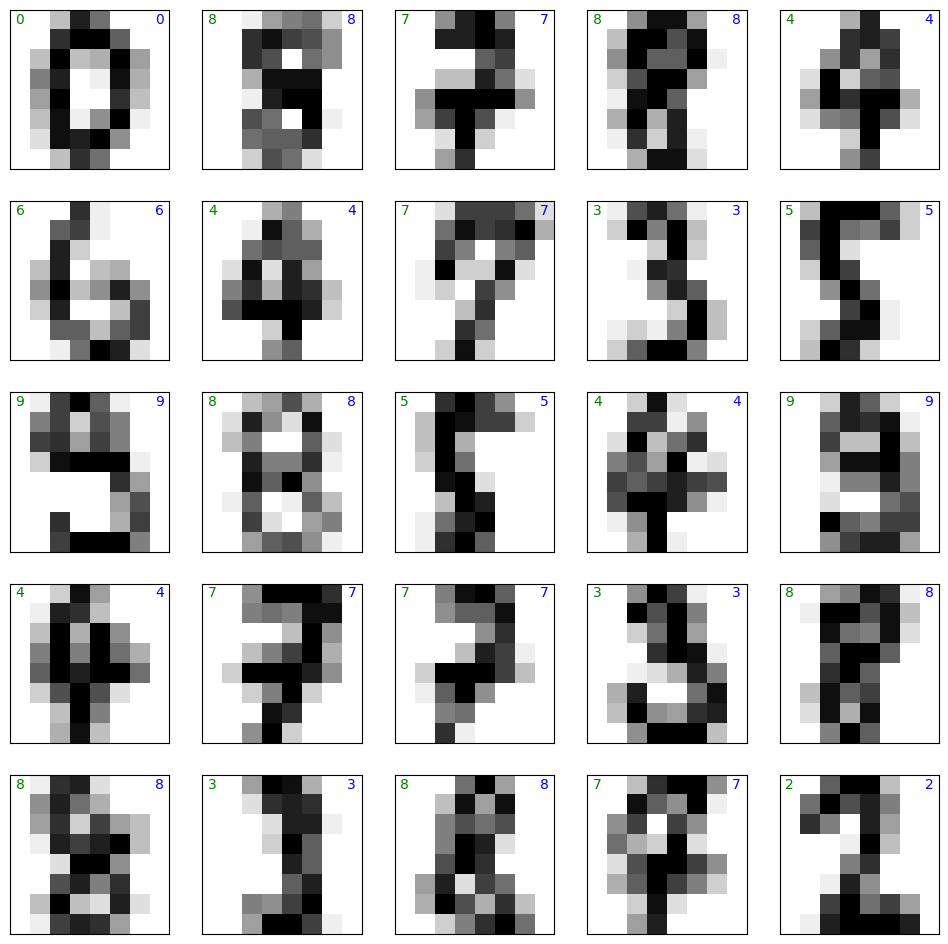

In [62]:
# Graficar los resultados cuando el valor predicho y original son iguales
print("Resultados cuando el valor predicho y original son iguales:")
mostrar_resultados(digits, knn_model, label='correctos')

En un lado esta el valor original (derecha) y en el otro el predicho (izquierda). En todos los casos anteriores se ve bastante bien.

Veamos para cuales dígitos se equivoca:

Resultados cuando el valor predicho y el original son distintos:


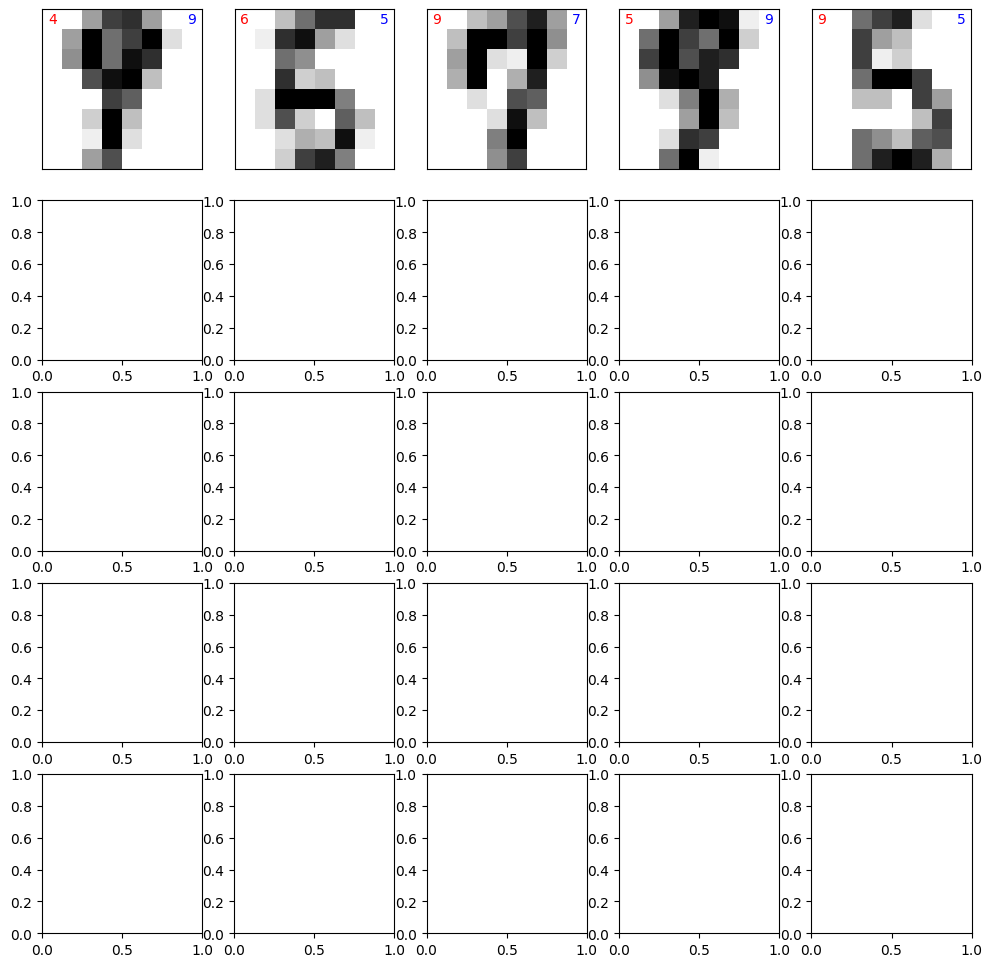

In [63]:
# Graficar los resultados cuando el valor predicho y original son distintos
print("Resultados cuando el valor predicho y el original son distintos:")
mostrar_resultados(digits, knn_model, label="incorrectos")

La clase 9 es la que más se confunde. Notar que son pocos los dígitos en los que se equivoca.

### Ejercicio 6
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

En este caso, donde la cantidad de datos es uniforme para las 10 clases, de tipo entero y utilizando un total de 912.7 KB de memoria, se buscó determinar el mejor modelo para determinar qué numero se representa.

Evaluamos la predicción de tres modelos para una dataset de más de una clase.

Entre todos, seleccionamos aquel que menos diera False Positive y False Negative, en este caso, el modelo K-Nearest Neighbors, dado el valor de accuracy y la cantidad de clases.

Corroboramos los resultados pues la curva AUC-ROC nos dan todas las clases con valores cercanos a 1, salvo dos clases. Esto es, los valores de los True Positive no son menores a los de False Positive.

Por lo que para problemas de este tipo, con datos de cantidad uniforme, bien distribuidos, y con una cantidad de 10 clases, será útil el modelo KNN.